In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

(-1.0595327718040621,
 0.9895327718040622,
 -0.49177443340691684,
 0.6626744334069168)

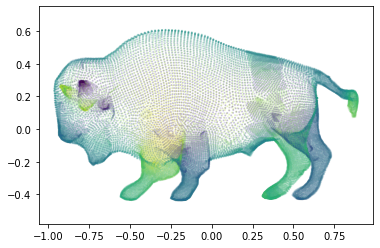

In [6]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [7]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### Create model and train

In [8]:
embedder = tfUMAP(
    direct_embedding=False,
    n_components = 64,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    n_neighbors = 150,
    decoding_method="autoencoder", 
)

In [9]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(decoding_method='autoencoder', negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f74926aacc0>,
       tensorboard_logdir='/tmp/tensorboard/20200714-101200',
       training_epochs=5)
Construct fuzzy simplicial set
Tue Jul 14 10:12:02 2020 Finding Nearest Neighbors
Tue Jul 14 10:12:02 2020 Building RP forest with 16 trees
Tue Jul 14 10:12:03 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
Tue Jul 14 10:12:34 2020 Finished Nearest Neighbor Search
Tue Jul 14 10:12:49 2020 Embedding with TensorFlow


Tue Jul 14 10:23:10 2020 Finished embedding


### Plot model output

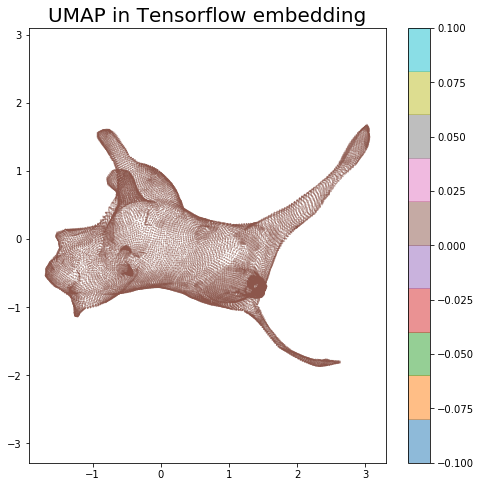

In [10]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [11]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [12]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
[]


,wall_time,step,val,group,variable
0,1.594747e+09,1,2.090196,train,umap_loss
1,1.594747e+09,2,1.957994,train,umap_loss
2,1.594747e+09,3,1.844422,train,umap_loss


Text(0.5, 1.0, 'Reconstruction loss')

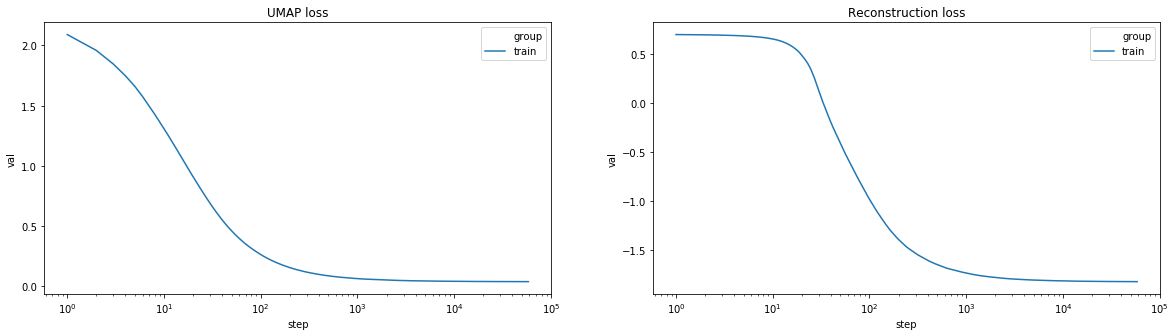

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Reconstruction loss')

### Save output

In [14]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [15]:
output_dir = MODEL_DIR/'projections'/ 'bison' / '64' / 'autoencoder'
ensure_dir(output_dir)

In [16]:
embedder.save(output_dir)

Pickle of model saved


W0714 10:23:37.849770 140141638494016 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0714 10:23:37.945261 140141638494016 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/64/autoencoder/encoder/assets


Encoder Keras model saved


I0714 10:23:38.465070 140141638494016 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/64/autoencoder/decoder/assets


Decoder Keras model saved


In [17]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [18]:
np.save(output_dir / 'z.npy', z)